In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import gensim as gs
import gensim
import torch.utils.data as D
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
import seaborn as sn
from sklearn.metrics import confusion_matrix
from gensim.models import FastText
from gensim.models.phrases import Phrases, Phraser

In [2]:
def load_lex_data2(dataset_name, feature_set=["t"]):
    print("loading lex data for", dataset_name, feature_set)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    inputs = dataset[feature_set]
    train_x, val_x, train_y, val_y = train_test_split(inputs, targets, test_size=0.2)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2)
    return print(len(train_x), len(val_x), len(test_x))

In [3]:
load_lex_data2("norm_tweet")

loading lex data for norm_tweet ['t']
3777 1181 945


In [2]:
def plot_intersection(file_name, plot_type, y1, y2, x, desc=True, intersection=False):
    y1, y2  = np.asarray(y1), np.asarray(y2)
    fig = plt.figure()
    plt.clf()
    if plot_type == "f1_score":
        max_y, max_x = round(max(y2),2), y2.tolist().index(max(y2))+1
        max_x = max_x * 250
        desc = "\ndataset: {}\nbest validation_f1_score = {}, in epoch {}\n blue=train_f1, green=val_f1".format(
                file_name, round(max_y,2), max_x)
        plt.plot(x, y1, "b-", x, y2, "g-", max_x, max_y, "ro")
        plt.ylim(0,1.1)
    elif plot_type == "loss":
        desc = "\ndataset: {}\n blue=train_f1, green=val_f1".format(file_name)
        plt.plot(x, y1, "b-", x, y2, "g-")
        plt.ylim(0,max([round(max(y1),2), round(max(y2),2)])+0.1)
    plt.ylabel(plot_type)
    plt.xlabel("epochs")
    plt.xticks(np.arange(500, 5001, 500))
    plt.grid()
    plt.xlim(0, 5000)
    fig.text(0.5, -0.15, desc.replace("../logs/", ""), ha='center')
    plt.show()
    #fig.savefig("{}{}_{}{}".format("../img/", file_name, plot_type, "_intersection.png"), bbox_inches="tight")
    plt.close(fig)

20 20
20 20


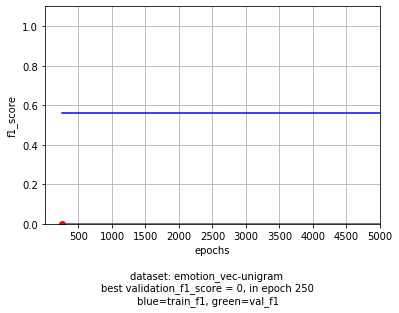

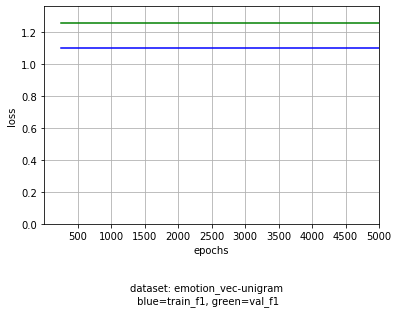

In [16]:
x = np.arange(250, 5001, 250)
#x = np.arange(1, 21,1)
train_f1 = [0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625,0.5625]
val_f1 =   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
print(len(train_f1), len(val_f1))
train_loss = [
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038,
    1.100030541419983,
    1.1000303030014038,
    1.1000303030014038,
    1.1000304222106934,
    1.1000303030014038,
    1.1000303030014038,
    1.1000303030014038
]

val_loss = [
    1.2560145854949951,
    1.2560147047042847,
    1.2560145854949951,
    1.2560144662857056,
    1.2560145854949951,
    1.2560145854949951,
    1.2560145854949951,
    1.2560145854949951,
    1.2560144662857056,
    1.2560144662857056,
    1.2560144662857056,
    1.2560145854949951,
    1.2560145854949951,
    1.2560144662857056,    
    1.256014347076416,
    1.2560144662857056,
    1.256014347076416,
    1.256014347076416,
    1.256014347076416,
    1.256014347076416,
]
print(len(train_loss), len(val_loss))
d = "emotion_vec-unigram"
plot_intersection(d, "f1_score", train_f1, val_f1, x)
plot_intersection(d, "loss", train_loss, val_loss, x)

In [7]:
def load_lex_data(dataset_name, feature_set_name, features, batch_size, split_factor=0.2):
    print("loading lex data", dataset_name, feature_set_name)
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    inputs = dataset[features]
    return make_loader(inputs, targets, split_factor)
    
def load_vector_data(dataset_name, bgr=False, split_factor=0.2):
    print("loading vector data for", dataset_name)
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")["a"]
    vector_model = FastText.load("../models/word_embeddings/" + dataset_name + "_fasttext")
    # replace placeholders (" "), make one-string-sentences
    print("... replacing placeholders")
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter((" ").__ne__, sample))
    inputs = [" ".join(sentence) for sentence in sentences]
    tokenized = sentences
    if bgr:
        bigram = Phraser.load("../models/bigrams/bigram_" + dataset_name + ".pkl")
        bigrammed = [bigram[sentence] for sentence in sentences]
        tokenized = bigrammed
    inputs = [np.sum(vector_model.wv[sent], 0).tolist() if sent else np.zeros(32) for sent in tokenized]   
    inputs = np.array(inputs)
    train_loader, val_loader, test_loader = make_loader(inputs, targets, split_factor)
    return len(inputs[0]), train_loader, val_loader, test_loader

def load_topic_data(dataset_name, split_factor=0.2):
    print("loading lex data", dataset_name)
    inputs = []
    num_topics = num_topics_dict[dataset_name]
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    dataset = dataset.astype(str).values.tolist() 
    dic = gs.corpora.Dictionary.load("../models/dictionary/" + dataset_name + "_dictionary")
    lda_model = gensim.models.ldamulticore.LdaMulticore.load("../models/topic_models/" + dataset_name + "_ldamodel")   
    print("../models/topic_models/" + dataset_name + "_ldamodel")
    for index, sample in enumerate(dataset): 
        dataset[index] = list(filter((" ").__ne__, sample))
    for i, sample in enumerate(dataset):
        sentence = dic.doc2bow(dataset[i])
        topics = lda_model.get_document_topics(sentence, minimum_probability=0.0)
        topic_vec = [topics[i][1] for i in range(num_topics)] 
        inputs.append(topic_vec)
    train_loader, val_loader, test_loader = make_loader(inputs, targets, split_factor)
    topics_num = len(lda_model.get_topics())
    return topics_num, train_loader, val_loader, test_loader
    

def make_loader(inputs, targets, test_size):
    # make train and test sets
    train_x, val_x, train_y, val_y = train_test_split(inputs, targets, test_size=test_size)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=test_size)
    train_data = MyDataset(np.asarray(train_x), np.asarray(train_y))
    val_data = MyDataset(np.asarray(val_x), np.asarray(val_y))
    test_data = MyDataset(np.asarray(test_x), np.asarray(test_y))
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_data, batch_size=round(batch_size*test_size))
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    return train_loader, val_loader, test_loader

In [8]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers):
        super(Lin_Net, self).__init__()
        self.act_function = nn.ReLU()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(0, num_hidden_layers)])
        self.lin4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act_function(self.lin1(x))
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.act_function(hidden_layer(x))
        x = self.lin4(x)
        return x
    
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
def test(test_loader, net, file_name): 
    print("testing")
    all_targets, preds, test_e = [], [], []
    net.eval()
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, test_targets = inputs.float(), targets.long()
        test_pred = net(inputs).tolist()[0]
        preds.append(test_pred.index(max(test_pred)))
        all_targets.append(test_targets.tolist()[0])
    test_f1 = f1_score(all_targets, preds, average="weighted")
    with open("../reports/report_"+file_name+".txt", 'w') as f:
        print(file_name + ", f1_score: " + str(test_f1) + ":\n\n" + 
          classification_report(all_targets, preds,target_names=classes), file=f)
    print(test_f1)
    draw_confusion_matrix(file_name, all_targets, preds, test_f1)
    
def run(dataset_name, feature_set_name):
    file_name = "net_lin_{}({})".format(dataset_name, feature_set_name)
    print("running ", file_name)
    if feature_set_name == "topics":
        num_topics, train_loader, val_loader, test_loader = load_topic_data(dataset_name)
        net = Lin_Net(num_topics, output_dim, hidden_dim, num_hidden_layers)
        net.load_state_dict(torch.load("../nets/net_lin_" + dataset_name+"_"+feature_set_name +"/net_lin_" + dataset_name +"("+feature_set_name+")_5000.pt",map_location=torch.device('cpu')))
        test(test_loader, net, file_name)
    elif feature_set_name == "vec-unigram":
        input_dim, train_loader, val_loader, test_loader = load_vector_data(dataset_name)
        net = Lin_Net(input_dim, output_dim, hidden_dim, num_hidden_layers)
        net.load_state_dict(torch.load("../nets/net_lin_" + dataset_name+"_"+feature_set_name +"/net_lin_" + dataset_name +"("+feature_set_name+")_5000.pt",map_location=torch.device('cpu')))
        test(test_loader, net, file_name)
    elif feature_set_name == "vec-bigram":
        input_dim, train_loader, val_loader, test_loader = load_vector_data(dataset_name, True)
        net = Lin_Net(input_dim, output_dim, hidden_dim, num_hidden_layers)
        net.load_state_dict(torch.load("../nets/net_lin_" + dataset_name+"_"+feature_set_name +"/net_lin_" + dataset_name +"("+feature_set_name+")_5000.pt",map_location=torch.device('cpu')))
        test(test_loader, net, file_name)
    else: 
        train_loader, val_loader, test_loader = load_lex_data(dataset_name, feature_set_name, feature_sets[dataset_name + "_" + feature_set_name], batch_size, split_factor)
        net = Lin_Net(len(feature_sets[dataset_name + "_" + feature_set_name]), output_dim, hidden_dim, num_hidden_layers)
        net.load_state_dict(torch.load("../nets/net_lin_" + dataset_name+"_"+feature_set_name +"/net_lin_" + dataset_name +"("+feature_set_name+")_5000.pt",map_location=torch.device('cpu')))
        test(test_loader, net, file_name)
        
def draw_confusion_matrix(file_name, test_y, pred_y, f1_score): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    desc = "dataset: {}".format(file_name)
    #if feature_set_name == "topics": desc = "dataset: {} ({}), trained with {} topics\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_topics, round(score,2), round(f1_scoore,2))
    #else: desc = "dataset: {} ({}) \nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, round(score,2), round(f1_scoore,2)) 
    desc = "dataset: {} ({}) \nf1_score: {}".format(dataset_name, feature_set_name, round(f1_score,2)) 
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    #fig.savefig("{}{}_{}".format("../img/", file_name, "confusion.png"), bbox_inches="tight")
    plt.close(fig)

running  net_lin_norm_emotion(vec-unigram)
loading vector data for norm_emotion


/home/marcel/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


... replacing placeholders
testing


/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marcel/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.22656730888185614


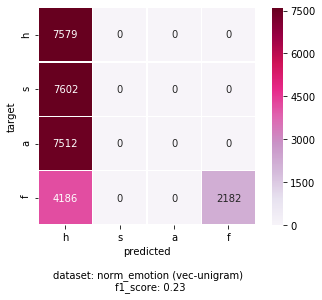

In [27]:
num_topics_dict = {
    "norm_emotion": 186,
    "norm_tweet": 79,
    "norm_test": 79
}
classes = ["happiness", "sadness", "anger", "fear"]
feature_sets = {
    "norm_test_full": ["wc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "norm_test_lex": ["hc", "sc", "ac", "fc"],
    "norm_emotion_full": ["wc", "ewc", "hc", "sc", "ac", "fc"],
    "norm_emotion_lex": ["hc", "sc", "ac", "fc"],
    "norm_tweet_full": ["wc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    "norm_tweet_lex": ["hc", "sc", "ac", "fc"]
}
cuda = torch.cuda.is_available()
batch_size = 16
epochs = 2500 + 1
print_every = 125
split_factor = 0.2
output_dim = 4
hidden_dim = 256
num_hidden_layers = 2
lr = 0.01

dataset_name = "norm_emotion"
feature_set_name = "vec-unigram"

run(dataset_name, feature_set_name)